# **THE PROMOTION PARADOX:**
### *Fixing Biased Talent Promotion Decisions Through Data-Driven HR Analytics*

**Final project by Syntax Society**
- Bayu Maitra
- Dian Ulhaq
- Febiansyah Ahnaf
- Keisya Nisrina Aulia
- Maslahatul Husna

# **IMPORT TOOLS & LOAD DATASET**

In [19]:
# Import library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

rcParams['figure.figsize'] = (15, 5)
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [20]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_project_kelompok_1/dataset/dataset_clean_unscaled.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Performance_Score,Leadership_Score,Training_Hours,Projects_Handled,Peer_Review_Score,Promotion_Eligible,Leadership_Index,Performance_Index,Potential_Index,Growth_Momentum,Leadership_Influence,Performance_Consistency
0,2.0,44.0,42.0,19.0,61.0,0.0,54.2,23.1,50.0,0.441860,1.355556,38.0
1,5.0,45.0,66.0,11.0,6.0,0.0,21.6,6.5,37.8,0.164179,0.130435,55.0
2,5.0,19.0,96.0,6.0,86.0,0.0,59.2,29.5,76.6,0.061856,4.300000,30.0
3,4.0,51.0,16.0,6.0,52.0,0.0,51.6,18.8,37.4,0.352941,1.000000,24.0
4,4.0,64.0,57.0,16.0,59.0,0.0,61.0,22.9,59.2,0.275862,0.907692,64.0


# **TREE_BASED MODELS**

## **Split & balancing for df_raw**

In [21]:
# split data and handle class imbalance for df_raw

df_raw = df.copy()

X_raw = df_raw.drop(columns=['Promotion_Eligible'])
y_raw = df_raw['Promotion_Eligible']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

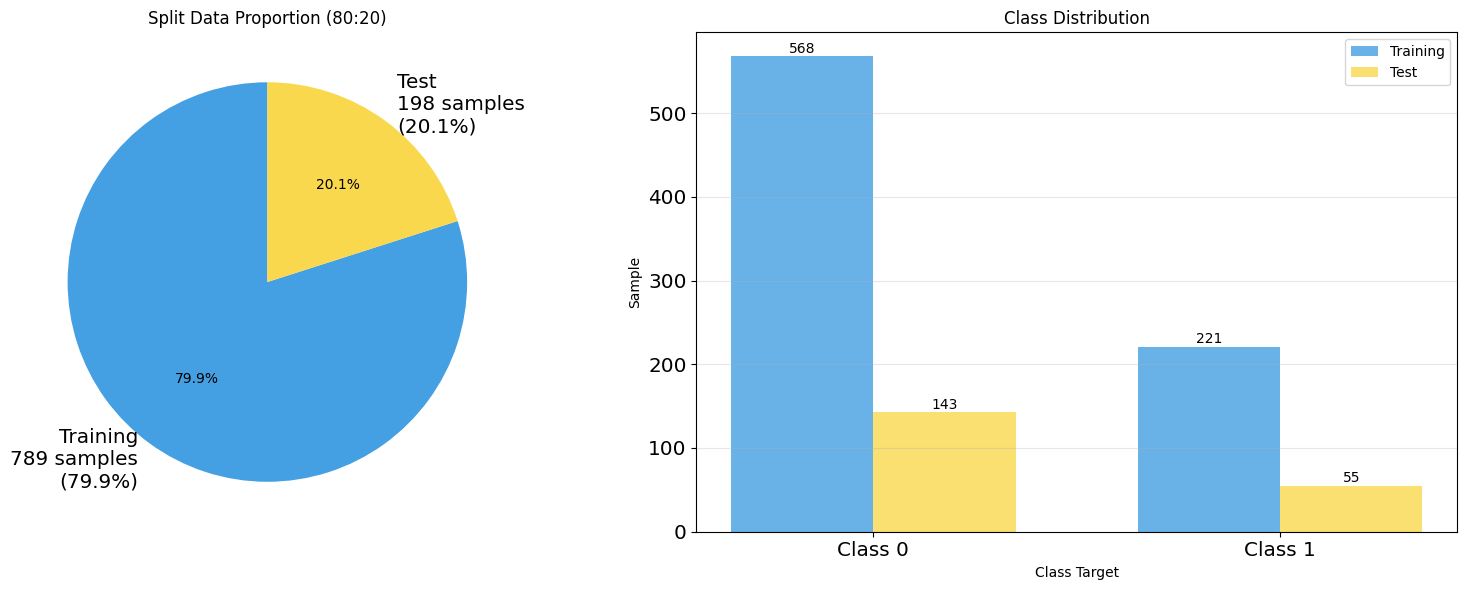

In [ ]:
total_samples = len(df_raw)
train_samples = len(X_train_raw)
test_samples = len(X_test_raw)

# Visualisasi split data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Split overall
split_data = [train_samples, test_samples]
split_labels = [f'Training\n{train_samples} samples\n({train_samples/total_samples*100:.1f}%)',
                f'Test\n{test_samples} samples\n({test_samples/total_samples*100:.1f}%)']

ax1.pie(split_data, labels=split_labels, autopct='%1.1f%%',
        colors=['#449fe3', '#f9d84e'], startangle=90)
ax1.set_title('Split Data Proportion (80:20)')

# Plot 2: Detail distribusi kelas
class_0_train = (y_train_raw == 0).sum()
class_1_train = (y_train_raw == 1).sum()
class_0_test = (y_test_raw == 0).sum()
class_1_test = (y_test_raw == 1).sum()

x = ['Class 0', 'Class 1']
train_values = [class_0_train, class_1_train]
test_values = [class_0_test, class_1_test]

x_pos = np.arange(len(x))
bar_width = 0.35

ax2.bar(x_pos - bar_width/2, train_values, bar_width, label='Training',
        color='#449fe3', alpha=0.8)
ax2.bar(x_pos + bar_width/2, test_values, bar_width, label='Test',
        color='#f9d84e', alpha=0.8)

ax2.set_xlabel('Class Target')
ax2.set_ylabel('Sample')
ax2.set_title('Class Distribution')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Tambah nilai di atas bar
for i, v in enumerate(train_values):
    ax2.text(i - bar_width/2, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(test_values):
    ax2.text(i + bar_width/2, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **Decision Tree**


### **Baseline modeling**


In [ ]:
# Model
baseline_dt = DecisionTreeClassifier(random_state=42)

# Training model
baseline_dt.fit(X_train_raw, y_train_raw)

# Save model
baseline_results = {}

### **Baseline evaluation**

In [ ]:
# Predictions
baseline_train_pred = baseline_dt.predict(X_train_raw)
baseline_test_pred  = baseline_dt.predict(X_test_raw)

# Probabilities for ROC-AUC
baseline_train_proba = baseline_dt.predict_proba(X_train_raw)[:, 1]
baseline_test_proba  = baseline_dt.predict_proba(X_test_raw)[:, 1]

# Confusion Matrix
cm_train = confusion_matrix(y_train_raw, baseline_train_pred)
cm_test = confusion_matrix(y_test_raw, baseline_test_pred)

baseline_results = {
    "Train Accuracy": accuracy_score(y_train_raw, baseline_train_pred),
    "Test Accuracy": accuracy_score(y_test_raw, baseline_test_pred),
    "Train Precision": precision_score(y_train_raw, baseline_train_pred),
    "Test Precision": precision_score(y_test_raw, baseline_test_pred),
    "Train Recall": recall_score(y_train_raw, baseline_train_pred),
    "Test Recall": recall_score(y_test_raw, baseline_test_pred),
    "Train F1 Score": f1_score(y_train_raw, baseline_train_pred),
    "Test F1 Score": f1_score(y_test_raw, baseline_test_pred),
    "ROC-AUC Train": roc_auc_score(y_train_raw, baseline_train_proba),
    "ROC-AUC Test": roc_auc_score(y_test_raw, baseline_test_proba),
}
df_baseline = pd.DataFrame(baseline_results, index=["Baseline Decision Tree"]).T
display(df_baseline)

# Confusion Matrix (Train)
df_cm_train = pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Train) ===")
display(df_cm_train)

# Confusion Matrix (Test)
df_cm_test = pd.DataFrame(
    cm_test,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Test) ===")
display(df_cm_test)

,Baseline Decision Tree
Train Accuracy,1.000000
Test Accuracy,0.611111
Train Precision,1.000000
Test Precision,0.310345
Train Recall,1.000000
Test Recall,0.327273
Train F1 Score,1.000000
Test F1 Score,0.318584
ROC-AUC Train,1.000000
ROC-AUC Test,0.523776



=== Confusion Matrix (Train) ===


,Pred 0,Pred 1
Actual 0,568,0
Actual 1,0,221



=== Confusion Matrix (Test) ===


,Pred 0,Pred 1
Actual 0,103,40
Actual 1,37,18


### **Tuned model**

In [ ]:
# Hyperparameter Grid
dt_params = {
    "max_depth": [3, 4, 5, 6, 8],
    "min_samples_split": [10, 20, 30, 40, 50],
    "min_samples_leaf": [5, 10, 15, 20],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"]
}

# Model
dt = DecisionTreeClassifier(random_state=42)

# Grid Search
grid_dt = GridSearchCV(estimator=dt, param_grid=dt_params, cv=5, scoring="f1", n_jobs=-1, verbose=1)

# Training model
grid_dt.fit(X_train_raw, y_train_raw)

# Best Model
best_dt = grid_dt.best_estimator_
print("Best Parameters:", grid_dt.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 10}


### **Tuning evaluation**

In [ ]:
# Predictions
dt_train_pred = best_dt.predict(X_train_raw)
dt_test_pred  = best_dt.predict(X_test_raw)

# Probabilities for ROC-AUC
dt_train_proba = best_dt.predict_proba(X_train_raw)[:, 1]
dt_test_proba  = best_dt.predict_proba(X_test_raw)[:, 1]

# Confusion Matrix
cm_train = confusion_matrix(y_train_raw, dt_train_pred)
cm_test = confusion_matrix(y_test_raw, dt_test_pred)

dt_results = {
    "Train Accuracy": accuracy_score(y_train_raw, dt_train_pred),
    "Test Accuracy": accuracy_score(y_test_raw, dt_test_pred),
    "Train Precision": precision_score(y_train_raw, dt_train_pred),
    "Test Precision": precision_score(y_test_raw, dt_test_pred),
    "Train Recall": recall_score(y_train_raw, dt_train_pred),
    "Test Recall": recall_score(y_test_raw, dt_test_pred),
    "Train F1 Score": f1_score(y_train_raw, dt_train_pred),
    "Test F1 Score": f1_score(y_test_raw, dt_test_pred),
    "ROC-AUC Train": roc_auc_score(y_train_raw, dt_train_proba),
    "ROC-AUC Test": roc_auc_score(y_test_raw, dt_test_proba),
}
df_dt = pd.DataFrame(dt_results, index=["Tuned Decision Tree"]).T
display(df_dt)

# Confusion Matrix (Train)
df_cm_train = pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Train) ===")
display(df_cm_train)

# Confusion Matrix (Test)
df_cm_test = pd.DataFrame(
    cm_test,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Test) ===")
display(df_cm_test)

,Tuned Decision Tree
Train Accuracy,0.721166
Test Accuracy,0.661616
Train Precision,0.507463
Test Precision,0.269231
Train Recall,0.153846
Test Recall,0.127273
Train F1 Score,0.236111
Test F1 Score,0.172840
ROC-AUC Train,0.587152
ROC-AUC Test,0.484234



=== Confusion Matrix (Train) ===


,Pred 0,Pred 1
Actual 0,535,33
Actual 1,187,34



=== Confusion Matrix (Test) ===


,Pred 0,Pred 1
Actual 0,124,19
Actual 1,48,7


## **Random Forest**


### **Modeling**


In [ ]:
# Model
random_forest = RandomForestClassifier(random_state=42)

# Training Model
random_forest.fit(X_train_raw, y_train_raw)

# Save model
rf_results = {}

### **Model evaluation**

In [ ]:
# Predictions
rf_train_pred = random_forest.predict(X_train_raw)
rf_test_pred =random_forest.predict(X_test_raw)

# Probability Prediction (untuk ROC-AUC)
rf_train_proba = random_forest.predict_proba(X_train_raw)[:, 1]
rf_test_proba = random_forest.predict_proba(X_test_raw)[:, 1]

# Confusion Matrix
cm_train_rf = confusion_matrix(y_train_raw, rf_train_pred)
cm_test_rf = confusion_matrix(y_test_raw, rf_test_pred)

rf_results["Random Forest"] = {
    "Train Accuracy": accuracy_score(y_train_raw, rf_train_pred),
    "Test Accuracy": accuracy_score(y_test_raw, rf_test_pred),
    "Train Precision": precision_score(y_train_raw, rf_train_pred),
    "Test Precision": precision_score(y_test_raw, rf_test_pred),
    "Train Recall": recall_score(y_train_raw, rf_train_pred),
    "Test Recall": recall_score(y_test_raw, rf_test_pred),
    "Train F1 Score": f1_score(y_train_raw, rf_train_pred),
    "Test F1 Score": f1_score(y_test_raw, rf_test_pred),
    "ROC-AUC Train": roc_auc_score(y_train_raw, rf_train_proba),
    "ROC-AUC Test": roc_auc_score(y_test_raw, rf_test_proba),
}
df_rf = pd.DataFrame(rf_results).T.transpose()
display(df_rf)

# Confusion Matrix (Train)
df_cm_train_rf = pd.DataFrame(
    cm_train_rf,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Train) ===")
display(df_cm_train_rf)

# Confusion Matrix (Test)
df_cm_test_rf = pd.DataFrame(
    cm_test_rf,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Test) ===")
display(df_cm_test_rf)

,Random Forest
Train Accuracy,1.000000
Test Accuracy,0.671717
Train Precision,1.000000
Test Precision,0.222222
Train Recall,1.000000
Test Recall,0.072727
Train F1 Score,1.000000
Test F1 Score,0.109589
ROC-AUC Train,1.000000
ROC-AUC Test,0.553973



=== Confusion Matrix (Train) ===


,Pred 0,Pred 1
Actual 0,568,0
Actual 1,0,221



=== Confusion Matrix (Test) ===


,Pred 0,Pred 1
Actual 0,129,14
Actual 1,51,4


### **Tuned model**

In [ ]:
# Model
tuned_rf = RandomForestClassifier(random_state=42)

# Hyperparameter Grid
param_rf = {
    "n_estimators": [50, 100, 150],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    "class_weight": ["balanced"]
}
# Grid Search
grid_rf = GridSearchCV(tuned_rf, param_rf, cv=10, scoring="f1", n_jobs=-1)

# Training model
grid_rf.fit(X_train_raw, y_train_raw)

# Save model
rf_tuned_results = {}

# Best model
rf_best = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### **Tuning evaluation**

In [ ]:
# Predictions
rf_tuned_train_pred = rf_best.predict(X_train_raw)
rf_tuned_test_pred = rf_best.predict(X_test_raw)

# Probability Prediction (untuk ROC-AUC)
rf_tuned_train_proba = rf_best.predict_proba(X_train_raw)[:, 1]
rf_tuned_test_proba = rf_best.predict_proba(X_test_raw)[:, 1]

# Confusion Matrix
cm_rf_tuned_train = confusion_matrix(y_train_raw, rf_tuned_train_pred)
cm_rf_tuned_test = confusion_matrix(y_test_raw, rf_tuned_test_pred)

rf_tuned_results["Tuned Random Forest"] = {
    "Train Accuracy": accuracy_score(y_train_raw, rf_tuned_train_pred),
    "Test Accuracy": accuracy_score(y_test_raw, rf_tuned_test_pred),
    "Train Precision": precision_score(y_train_raw, rf_tuned_train_pred),
    "Test Precision": precision_score(y_test_raw, rf_tuned_test_pred),
    "Train Recall": recall_score(y_train_raw, rf_tuned_train_pred),
    "Test Recall": recall_score(y_test_raw, rf_tuned_test_pred),
    "Train F1 Score": f1_score(y_train_raw, rf_tuned_train_pred),
    "Test F1 Score": f1_score(y_test_raw, rf_tuned_test_pred),
    "ROC-AUC Train": roc_auc_score(y_train_raw, rf_tuned_train_proba),
    "ROC-AUC Test": roc_auc_score(y_test_raw, rf_tuned_test_proba),
}
df_rf_tuned = pd.DataFrame(rf_tuned_results).T.transpose()
display(df_rf_tuned)

# Confusion Matrix (Train)
df_rf_cm_train_tuned = pd.DataFrame(
    cm_rf_tuned_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Train) ===")
display(df_rf_cm_train_tuned)

# Confusion Matrix (Test)
df_rf_cm_test_tuned = pd.DataFrame(
    cm_rf_tuned_test,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Test) ===")
display(df_rf_cm_test_tuned)


,Tuned Random Forest
Train Accuracy,0.754119
Test Accuracy,0.555556
Train Precision,0.539823
Test Precision,0.301205
Train Recall,0.828054
Test Recall,0.454545
Train F1 Score,0.653571
Test F1 Score,0.362319
ROC-AUC Train,0.856128
ROC-AUC Test,0.542530



=== Confusion Matrix (Train) ===


,Pred 0,Pred 1
Actual 0,412,156
Actual 1,38,183



=== Confusion Matrix (Test) ===


,Pred 0,Pred 1
Actual 0,85,58
Actual 1,30,25


## **XGBoost**

### **Modeling**

In [ ]:
# Model
xgboost = XGBClassifier(random_state=42)

# Training model
xgboost.fit(X_train_raw, y_train_raw)

# Save model
xgboost_results = {}

### **Model evaluation**

In [ ]:
# Predictions
xgboost_train_pred = xgboost.predict(X_train_raw)
xgboost_test_pred = xgboost.predict(X_test_raw)

# Probability Prediction (untuk ROC-AUC)
xgb_train_proba = xgboost.predict_proba(X_train_raw)[:, 1]
xgb_test_proba = xgboost.predict_proba(X_test_raw)[:, 1]

# Confusion Matrix
cm_train_xgb = confusion_matrix(y_train_raw, xgboost_train_pred)
cm_test_xgb = confusion_matrix(y_test_raw, xgboost_test_pred)

xgboost_results["XGBoost"] = {
    "Train Accuracy": accuracy_score(y_train_raw, xgboost_train_pred),
    "Test Accuracy": accuracy_score(y_test_raw, xgboost_test_pred),
    "Train Precision": precision_score(y_train_raw, xgboost_train_pred),
    "Test Precision": precision_score(y_test_raw, xgboost_test_pred),
    "Train Recall": recall_score(y_train_raw, xgboost_train_pred),
    "Test Recall": recall_score(y_test_raw, xgboost_test_pred),
    "Train F1 Score": f1_score(y_train_raw, xgboost_train_pred),
    "Test F1 Score": f1_score(y_test_raw, xgboost_test_pred),
    "ROC-AUC Train": roc_auc_score(y_train_raw, xgb_train_proba),
    "ROC-AUC Test": roc_auc_score(y_test_raw, xgb_test_proba),
}
df_xgb = pd.DataFrame(xgboost_results).T.transpose()
display(df_xgb)

# Confusion Matrix (Train)
df_cm_train_xgb = pd.DataFrame(
    cm_train_xgb,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Train) ===")
display(df_cm_train_xgb)

# Confusion Matrix (Test)
df_cm_test_xgb = pd.DataFrame(
    cm_test_xgb,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Test) ===")
display(df_cm_test_xgb)


,XGBoost
Train Accuracy,1.000000
Test Accuracy,0.641414
Train Precision,1.000000
Test Precision,0.264706
Train Recall,1.000000
Test Recall,0.163636
Train F1 Score,1.000000
Test F1 Score,0.202247
ROC-AUC Train,1.000000
ROC-AUC Test,0.499555



=== Confusion Matrix (Train) ===


,Pred 0,Pred 1
Actual 0,568,0
Actual 1,0,221



=== Confusion Matrix (Test) ===


,Pred 0,Pred 1
Actual 0,118,25
Actual 1,46,9


### **Tuned model**

In [ ]:
# Model
pipe_xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Hyperparameter Grid
param_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.2, 0.001],
    "model__subsample": [0.7, 0.8],
    "model__colsample_bytree": [0.7, 0.8]
}

# Grid search
grid_xgb = GridSearchCV(pipe_xgb, param_xgb, cv=10, scoring="f1", n_jobs=-1)

# Training model
grid_xgb.fit(X_train_raw, y_train_raw)

# Save model
xgb_tuned_results = {}

# Best model
xgboost_best = grid_xgb.best_estimator_
print("Best Parameters:", grid_xgb.best_params_)

Best Parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.7}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:19:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "model__colsample_bytree", "model__learning_rate", "model__max_depth", "model__n_estimators", "model__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### **Tuning evaluation**

In [ ]:
# Predictions
xgb_tuned_train_pred = xgboost_best.predict(X_train_raw)
xgb_tuned_test_pred = xgboost_best.predict(X_test_raw)

# Probability Prediction (untuk ROC-AUC)
xgb_tuned_train_proba = xgboost_best.predict_proba(X_train_raw)[:, 1]
xgb_tuned_test_proba = xgboost_best.predict_proba(X_test_raw)[:, 1]

# Confusion Matrix
cm_xgb_tuned_train = confusion_matrix(y_train_raw, xgb_tuned_train_pred)
cm_xgb_tuned_test = confusion_matrix(y_test_raw, xgb_tuned_test_pred)

xgb_tuned_results["Tuned XGBoost"] = {
    "Train Accuracy": accuracy_score(y_train_raw, xgb_tuned_train_pred),
    "Test Accuracy": accuracy_score(y_test_raw, xgb_tuned_test_pred),
    "Train Precision": precision_score(y_train_raw, xgb_tuned_train_pred),
    "Test Precision": precision_score(y_test_raw, xgb_tuned_test_pred),
    "Train Recall": recall_score(y_train_raw, xgb_tuned_train_pred),
    "Test Recall": recall_score(y_test_raw, xgb_tuned_test_pred),
    "Train F1 Score": f1_score(y_train_raw, xgb_tuned_train_pred),
    "Test F1 Score": f1_score(y_test_raw, xgb_tuned_test_pred),
    "ROC-AUC Train": roc_auc_score(y_train_raw, xgb_tuned_train_proba),
    "ROC-AUC Test": roc_auc_score(y_test_raw, xgb_tuned_test_proba),
}
df_xgb_tuned = pd.DataFrame(xgb_tuned_results).T.transpose()
display(df_xgb_tuned)

# Confusion Matrix (Train)
df_xgb_cm_train_tuned = pd.DataFrame(
    cm_xgb_tuned_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Train) ===")
display(df_xgb_cm_train_tuned)


# Confusion Matrix (Test)
df_xgb_cm_test_tuned = pd.DataFrame(
    cm_xgb_tuned_test,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
)
print("\n=== Confusion Matrix (Test) ===")
display(df_xgb_cm_test_tuned)

,Tuned XGBoost
Train Accuracy,1.000000
Test Accuracy,0.641414
Train Precision,1.000000
Test Precision,0.264706
Train Recall,1.000000
Test Recall,0.163636
Train F1 Score,1.000000
Test F1 Score,0.202247
ROC-AUC Train,1.000000
ROC-AUC Test,0.499555



=== Confusion Matrix (Train) ===


,Pred 0,Pred 1
Actual 0,568,0
Actual 1,0,221



=== Confusion Matrix (Test) ===


,Pred 0,Pred 1
Actual 0,118,25
Actual 1,46,9


# 📊 Summary of Employee Promotion Classification Model Evaluation

## 🔍 Executive Summary
Based on the evaluation of three classification algorithms for predicting employee promotion eligibility, **Tuned Random Forest** shows the strongest performance with the most balanced trade-off between precision and recall.

---

## 📈 Model Performance Comparison

### **Baseline Models (Before Tuning)**

| Model           | Test Accuracy | Test F1-Score | Test Recall | ROC-AUC | Status               |
|-----------------|---------------|---------------|-------------|---------|-----------------------|
| Decision Tree   | 0.611         | 0.319         | 0.327       | 0.524   | ⚠️ Overfitting        |
| Random Forest   | 0.672         | 0.110         | 0.073       | 0.554   | ⚠️ Very Low Recall    |
| XGBoost         | 0.641         | 0.202         | 0.164       | 0.500   | ⚠️ Overfitting        |

---

### **Tuned Models (After Hyperparameter Tuning)**

| Model           | Test Accuracy | Test F1-Score | Test Precision | Test Recall | ROC-AUC |
|-----------------|---------------|---------------|----------------|-------------|---------|
| Decision Tree   | 0.662         | 0.173         | 0.269          | 0.127       | 0.484   |
| **Random Forest** | **0.556**   | **0.362**     | **0.301**      | **0.455**   | **0.543** |
| XGBoost         | 0.641         | 0.202         | 0.265          | 0.164       | 0.500   |

---

## 🏆 Best Model: **Tuned Random Forest**

### ✅ Strengths:
- **Highest Recall (0.455)** → identifies 45.5% of employees truly eligible for promotion  
- **Best F1-Score (0.362)** → strongest balance between precision and recall  
- **Better Generalization** → reasonable train–test gap  
- **Stable Metrics** → consistent ROC-AUC  

### ⚠️ Areas for Improvement:
- Low precision (0.301)  
- Test accuracy relatively low (55.6%)  
- Significant room for further optimization  

---

## 🚀 Recommended Additional Models

### **Supervised Learning Alternatives**
- Gradient Boosting  
- LightGBM  
- Support Vector Machine (SVM)  
- CatBoost (with stronger regularization & class weights)

### **Unsupervised Learning Alternatives**
- K-Means  
- K-Medoids  
- Gaussian Mixture Models (GMM)

---